In [ ]:
!pip install wandb

In [ ]:
import os
import wandb
import torch
import torch.nn as nn
import numpy as np
import random
from tqdm import *
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (25.0, 7.0)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
from pylab import meshgrid
import pandas as pd
from torch.utils.data import Dataset, TensorDataset, DataLoader

%matplotlib inline

In [ ]:
def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU

In [ ]:
def approx_function(x, y):
  return np.sin(x + 2 * y) * np.exp(-(2 * x + y) ** 2)

In [ ]:
x = np.random.uniform(low=-10.0, high=10.0, size=2000)
y = np.random.uniform(low=-10.0, high=10.0, size=2000) 

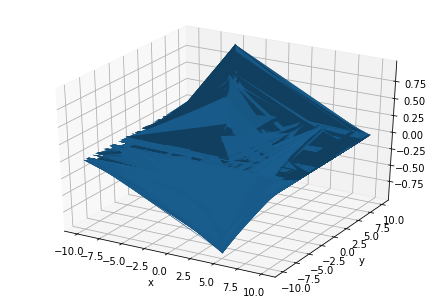

In [ ]:
X,Y = meshgrid(x, y)
Z = approx_function(X, Y)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
x_input = np.vstack((x, y)).T
y_input = approx_function(x, y)
x_train, x_test, y_train, y_test = train_test_split(x_input, y_input, test_size=0.33)

In [ ]:
x_train_tensor = torch.from_numpy(x_train)
y_train_tensor = torch.from_numpy(y_train)
x_test_tensor = torch.from_numpy(x_test)
y_test_tensor = torch.from_numpy(y_test)

In [ ]:
batch_size = 64
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size*2)

In [ ]:
class NNet(nn.Module):
  def __init__(self, n_hidden):
    super(NNet, self).__init__()
    self.fc1 = nn.Linear(2, n_hidden)
    self.act1 = nn.ReLU()
    self.fc2 = nn.Linear(n_hidden, n_hidden)
    self.act2 = nn.ReLU()
    self.fc3 = nn.Linear(n_hidden, 1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    return x

In [ ]:
nnet = NNet(32)

In [ ]:
optimizer = torch.optim.Adam(nnet.parameters(), lr = 0.001)

In [ ]:
def loss(pred, true):
  sq = (pred - true)**2
  return sq.mean()

In [ ]:
loss_func = torch.nn.MSELoss()

In [ ]:
os.environ['WANDB_API_KEY'] = '45ff1fa3e19372726a7943b497497ca2b8f16d65'
wandb.init(project='pytorch_practice', entity='miksadikov', reinit=True)
wandb.watch(nnet, log='all')

wandb: Currently logged in as: miksadikov. Use `wandb login --relogin` to force relogin


[]

In [ ]:
y_pred_numpy_ = np.array([])

In [ ]:
def predict(net, x, y):
  y_pred_numpy = np.array([])
  for x_ in x:
    x_ = x_.float()
    y_pred = net.forward(x_)
    y_pred_numpy = np.append(y_pred_numpy, y_pred.detach().numpy())

  x1, x2 = np.split(x, 2, axis=1)
  X1, X2 = meshgrid(x1, x2)
  fig = plt.figure()
  ax = Axes3D(fig)
  pred_out = y_pred_numpy.copy()
  y_pred_numpy = np.expand_dims(y_pred_numpy, axis=0)
  ax.plot_surface(X1, X2, y_pred_numpy)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()
  return(pred_out)

In [ ]:
for epoch in range(10000):   
  for xb, yb in train_dataloader:
    xb = xb.float()
    yb = yb.float()
    y_pred = nnet.forward(xb)
    loss_val = loss_func(torch.squeeze(y_pred), yb)
    loss_val.backward()
    optimizer.step()
    optimizer.zero_grad()
    wandb.log({'loss': loss_val})

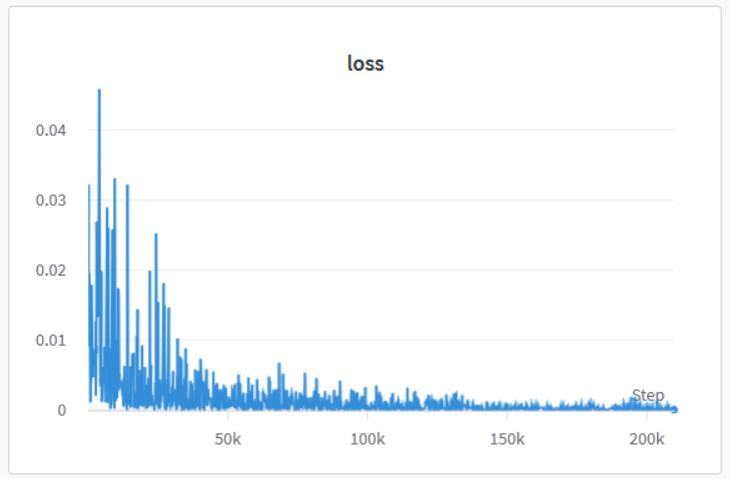

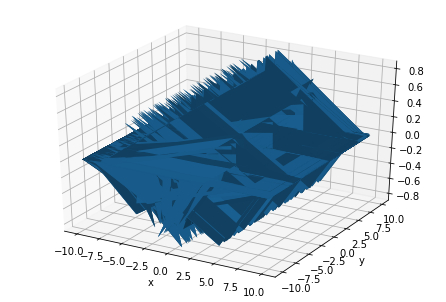

In [ ]:
y_pred_numpy_ = predict(nnet, x_test_tensor, y_test)

In [ ]:
y_ = np.take(y_input, [0, 1, 2, 3, 4])
y_pred_ = np.take(y_pred_numpy_, [0, 1, 2, 3, 4])
print(y_)
print(y_pred_)


[-1.22803661e-022  2.71494255e-012  3.26167637e-047  2.32693656e-189
  4.23681455e-054]
[0.00848848 0.00066625 0.01120549 0.0104773  0.01510217]


In [ ]:
approx = approx_function(5, 5)
train_ = (torch.from_numpy(np.array([5, 5]))).float()
approx_pred = (nnet.forward(train_)).detach().numpy()
print(approx)
print(approx_pred)

1.2498192368214491e-98
[-0.00766353]
